In [6]:
# one needs to import those packages which are needed; best to be done at the beginning of the program.
import networkx as nx
import networkx.algorithms.community as nx_comm
import numpy as np
import pandas as pd
import scipy as sp
import random as rn
from heapq import nlargest

# some basic settings for plotting figures
import matplotlib.pyplot as plt
%matplotlib inline 
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 32}

plt.rc('font', **font)
import community as community_louvain

In [7]:
G0 = nx.read_weighted_edgelist("4932.protein.links.v11.5.txt",comments="#",nodetype=str)

In [8]:
threshold_score = 700
for edge in G0.edges: 
    weight = list(G0.get_edge_data(edge[0],edge[1]).values())
    if(weight[0] <= threshold_score):
        G0.remove_edge(edge[0],edge[1])

In [4]:
# some basic information
print('number of nodes of G0:',G0.number_of_nodes())
print('number of edges of G0:',G0.number_of_edges())
print('Is the full G0 connected?',nx.connected.is_connected(G0))
print('How many connected subgraphs are there?',nx.connected.number_connected_components(G0))

number of nodes of G0: 6394
number of edges of G0: 120009
Is the full G0 connected? False
How many connected subgraphs are there? 441


In [9]:
#get the largest component
largest_cc = max(nx.connected_components(G0),key=len)
G = G0.subgraph(largest_cc)
print('Type',type(largest_cc))
print('number of nodes of largest connected subgraph of G:',G.number_of_nodes())
print('number of edges of largest connected subgraph of G0:',G.number_of_edges())

Type <class 'set'>
number of nodes of largest connected subgraph of G: 5932
number of edges of largest connected subgraph of G0: 119977


In [10]:
# remove the essential nodes from G0
ess=pd.read_csv("essential_pro.csv",header=None)
ess_pro=pd.Series.to_list(ess[1])
for i in range(len(ess_pro)):
    ess_pro[i]='4932.'+ess_pro[i]
G0.remove_nodes_from(ess_pro)

In [11]:
# new information 53343
print('number of nodes of G0 without essential nodes:',G0.number_of_nodes())
print('number of edges of G0 without essential nodes:',G0.number_of_edges())

number of nodes of G0 without essential nodes: 5098
number of edges of G0 without essential nodes: 53343


In [12]:
# narrow our selection to the proteins connected to ours
nodes = nx.shortest_path(G0,'4932.YKL126W').keys()
G=G0.subgraph(nodes)

In [11]:
# some basic information #3
print('number of nodes of G:',G.number_of_nodes())
print('number of edges of G:',G.number_of_edges())

number of nodes of G: 4639
number of edges of G: 53312


In [11]:
# nx.diameter(G)
#=8

In [19]:
# time to define a parent class of network
class Network:
    R = 1
    N = 10
    MIN_SIZE = 4

    def __init__(self, graph, homologue='4932.YKL126W', partition_method="nx_louvain"):
        self.graph = graph
        self.homologue = homologue
        self.partition_method = partition_method

        self.partitions = []
        self.homologue_communities = []
        self.homologue_members={}
        self.central_nodes = []
        self.important_nodes = {}
        self.homologue_index=[]
        self.community_neighbours=[]
        self.adjacent_communities = []
        self.central_nodes_neighbour = [] 
        self.important_nodes_neighbour = {}

    def set_partitions_robust(self):
        def find_partition(graph, partition_method, s):
            if partition_method == "nx_louvain":
                return nx_comm.louvain_communities(graph, resolution=Network.R, seed=s)

            if partition_method == "other_louvain":
                # some kind of community collection
                return None

        for i in range(Network.N):
            partition = find_partition(self.graph, self.partition_method, i)
            self.partitions.append(partition)

    def set_homologue_communities(self):
        for part in self.partitions:
            for i in range(len(part)):
                if self.homologue in part[i]:
                    sub = self.graph.subgraph(part[i])
                    self.homologue_communities.append(sub)
                    self.homologue_index.append(i)
                    break
    
    def count_homologue_comm_members(self):
        get_subgraph_nodes = lambda x: self.graph.subgraph(x).nodes
        homo_networks = map(get_subgraph_nodes, self.homologue_communities)
        # count the number of subgraph each node occurs in
        flat_comm_nodes = [y for x in homo_networks for y in x]
        for node in list(set(flat_comm_nodes)):
            self.homologue_members[node] = flat_comm_nodes.count(node)

    def set_central_nodes_robust(self):
        def find_central_nodes(community,n=5):
            """return a list of the most significant nodes
            according to three centrality measures"""
            deg = nx.degree_centrality(community)
            bet = nx.betweenness_centrality(community)
            eig = nx.eigenvector_centrality(community)
            top_n_deg = nlargest(n, deg, key=deg.get)
            top_n_bet = nlargest(n, bet, key=bet.get)
            top_n_eig = nlargest(n, eig, key=eig.get)
            return list({*top_n_deg,*top_n_bet,*top_n_eig})

        def find_c_nodes_neighbour(community, n=3):
            if len(community) < Network.MIN_SIZE: return []
            deg = nx.degree_centrality(community)
            bet = nx.betweenness_centrality(community)

            top_n_deg = nlargest(n, deg, key=deg.get)
            top_n_bet = nlargest(n, bet, key=bet.get)

            return list({*top_n_deg, *top_n_deg})

        for i in range(Network.N):
            self.central_nodes.append(find_central_nodes(self.homologue_communities[i]))
            neigh_networks = map(self.graph.subgraph, self.adjacent_communities[i])
            cen_neigh = map(find_c_nodes_neighbour, neigh_networks)
            self.central_nodes_neighbour.append(cen_neigh)

    def node_info(self, node, lst):
        spath = nx.shortest_path(self.graph, source=self.homologue, target=node)
        return {
            "times_occurred": lst.count(node),
            "distance": len(spath)
        }

    def set_important_nodes(self):
        # flatten the central nodes list
        flat_central_nodes = [y for x in self.central_nodes for y in x]    
        for node in set(flat_central_nodes):
            self.important_nodes[node] = self.node_info(node, flat_central_nodes)

    def set_important_nodes_neighbour(self):
        # flatten the central nodes list
        flat_central_nodes_1 = [y for x in self.central_nodes_neighbour for y in x]
        flat_central_nodes_2 = [y for x in flat_central_nodes_1 for y in x]
        for node in set(flat_central_nodes_2):
            self.important_nodes_neighbour[node] = self.node_info(node, flat_central_nodes_2)

    def find_neighbours(self):
        for comm in self.homologue_communities:
            nodes = comm.nodes
            neighs = set()
            for n in nodes:
                neighs.update([*self.graph.neighbors(n)])
            self.community_neighbours.append(neighs)

    def set_neighbour_communities(self):
        a = self.partitions.copy()
        for i, part in enumerate(a):
            del part[self.homologue_index[i]]
            neighs = self.community_neighbours[i]
            # all communities containing a neighbouring element
            nei_comm = [comm for comm in part if set(comm) & set(neighs) != set()]
            self.adjacent_communities.append(nei_comm)

    def get_partitions(self):
        return self.partitions

    def get_homologue_communities(self):
        return self.homologue_communities

    def get_central_nodes(self):
        return self.central_nodes
    
    def get_important_nodes(self):
        return self.important_nodes

In [22]:
akt2 = Network(G, '4932.YKL126W')

In [23]:
akt2.set_partitions_robust()
akt2.set_homologue_communities()

In [24]:
akt2.find_neighbours()
akt2.set_neighbour_communities()
akt2.set_central_nodes_robust()

In [26]:
akt2.set_important_nodes()
akt2.set_important_nodes_neighbour()
akt2.count_homologue_comm_members()

In [33]:
for part in sorted(akt2.get_partitions(), key=lambda x:len(x)):
    print(len(part), sorted([len(i) for i in part],reverse=True))

15 [812, 517, 413, 363, 296, 250, 228, 202, 190, 181, 155, 142, 133, 114, 107]
16 [861, 589, 377, 345, 312, 277, 241, 212, 184, 174, 155, 155, 128, 50, 36, 11]
16 [775, 621, 429, 375, 275, 235, 213, 198, 179, 155, 143, 140, 123, 123, 118, 19]
16 [802, 448, 414, 411, 286, 237, 215, 202, 191, 185, 159, 150, 140, 132, 105, 42]
17 [781, 525, 375, 358, 283, 246, 236, 223, 200, 186, 171, 139, 129, 118, 107, 23, 17]
17 [776, 396, 356, 312, 309, 271, 250, 217, 216, 216, 185, 169, 157, 110, 103, 28, 20]
17 [869, 423, 393, 384, 317, 288, 252, 213, 195, 183, 170, 169, 131, 126, 22, 19, 17]
18 [818, 567, 408, 392, 281, 233, 231, 195, 182, 177, 142, 138, 126, 119, 75, 19, 17, 7]
20 [466, 428, 363, 338, 327, 308, 248, 231, 207, 203, 202, 162, 158, 135, 129, 122, 53, 23, 17, 11]
20 [759, 431, 397, 365, 280, 275, 238, 208, 203, 186, 158, 128, 127, 107, 105, 69, 19, 17, 11, 6]


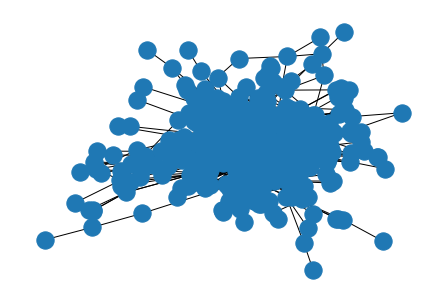

In [35]:
subnet_nodes = [*{
    node: akt2.homologue_members[node]
        for node in akt2.homologue_members \
            if akt2.homologue_members[node] >= 7
}.keys()]
subnet = G.subgraph(subnet_nodes)
nx.draw(subnet)

In [36]:
akt2.important_nodes_neighbour

{'4932.YDR261W-B': {'times_occurred': 1, 'distance': 6},
 '4932.YAL023C': {'times_occurred': 5, 'distance': 4},
 '4932.YER145C': {'times_occurred': 5, 'distance': 5},
 '4932.YCR031C': {'times_occurred': 2, 'distance': 3},
 '4932.YPL031C': {'times_occurred': 3, 'distance': 3},
 '4932.Q0010': {'times_occurred': 1, 'distance': 6},
 '4932.YPL013C': {'times_occurred': 3, 'distance': 4},
 '4932.Q0182': {'times_occurred': 3, 'distance': 6},
 '4932.YOR175C': {'times_occurred': 5, 'distance': 4},
 '4932.YJR146W': {'times_occurred': 5, 'distance': 5},
 '4932.YGL071W': {'times_occurred': 5, 'distance': 4},
 '4932.YKL170W': {'times_occurred': 1, 'distance': 3},
 '4932.YML032C': {'times_occurred': 5, 'distance': 4},
 '4932.YJR113C': {'times_occurred': 2, 'distance': 3},
 '4932.YBR169C': {'times_occurred': 5, 'distance': 3},
 '4932.YML014W': {'times_occurred': 3, 'distance': 4},
 '4932.YFR031C-A': {'times_occurred': 5, 'distance': 3},
 '4932.YPR044C': {'times_occurred': 3, 'distance': 5},
 '4932.YDL

In [37]:
akt2.important_nodes

{'4932.YKL113C': {'times_occurred': 1, 'distance': 4},
 '4932.YHL022C': {'times_occurred': 1, 'distance': 4},
 '4932.YLR362W': {'times_occurred': 9, 'distance': 3},
 '4932.YOR033C': {'times_occurred': 1, 'distance': 4},
 '4932.YGR040W': {'times_occurred': 9, 'distance': 4},
 '4932.YML032C': {'times_occurred': 1, 'distance': 4},
 '4932.YJR066W': {'times_occurred': 9, 'distance': 2},
 '4932.YLR433C': {'times_occurred': 7, 'distance': 3},
 '4932.YNL098C': {'times_occurred': 8, 'distance': 3},
 '4932.YBL016W': {'times_occurred': 9, 'distance': 4},
 '4932.YDR477W': {'times_occurred': 9, 'distance': 3},
 '4932.YOL012C': {'times_occurred': 1, 'distance': 3},
 '4932.YER095W': {'times_occurred': 1, 'distance': 3},
 '4932.YHR030C': {'times_occurred': 9, 'distance': 3},
 '4932.YLR113W': {'times_occurred': 9, 'distance': 3},
 '4932.YMR307W': {'times_occurred': 4, 'distance': 3},
 '4932.YBR010W': {'times_occurred': 1, 'distance': 3},
 '4932.YMR190C': {'times_occurred': 1, 'distance': 4},
 '4932.YHL

In [39]:
akt2.homologue_index

[6, 8, 16, 14, 15, 10, 14, 17, 12, 16]

In [40]:
akt2.partitions

[[{'4932.YAR035C-A',
   '4932.YBL001C',
   '4932.YBL012C',
   '4932.YBL044W',
   '4932.YBL083C',
   '4932.YBR022W',
   '4932.YBR032W',
   '4932.YBR046C',
   '4932.YBR071W',
   '4932.YBR144C',
   '4932.YBR196C-A',
   '4932.YBR197C',
   '4932.YBR203W',
   '4932.YBR209W',
   '4932.YBR255W',
   '4932.YBR259W',
   '4932.YBR266C',
   '4932.YBR298C-A',
   '4932.YBR300C',
   '4932.YCR102W-A',
   '4932.YDL242W',
   '4932.YDR215C',
   '4932.YGR247W',
   '4932.YIR040C',
   '4932.YJL222W-A',
   '4932.YJL222W-B',
   '4932.YKL098W',
   '4932.YLR087C',
   '4932.YLR296W',
   '4932.YMR126C',
   '4932.YNR072W',
   '4932.YOL118C',
   '4932.YOL119C',
   '4932.YOR285W',
   '4932.YPR027C',
   '4932.YPR153W'},
  {'4932.Q0045',
   '4932.Q0050',
   '4932.Q0055',
   '4932.Q0060',
   '4932.Q0065',
   '4932.Q0070',
   '4932.Q0075',
   '4932.Q0080',
   '4932.Q0085',
   '4932.Q0105',
   '4932.Q0110',
   '4932.Q0115',
   '4932.Q0120',
   '4932.Q0130',
   '4932.Q0250',
   '4932.Q0255',
   '4932.Q0275',
   '4932.YAL00

In [41]:
len([*G.neighbors("4932.YKL126W")])

35

In [43]:
nodes_n = akt2.adjacent_communities[0]
"4932.YKL126W" in [y for x in nodes_n for y in x]

False

In [44]:
len(nodes_n)

15

In [46]:
a = akt2.partitions[0]
len(a)

16

In [47]:
ypk1 = Network(G,homologue='4932.YKL126W')

In [ ]:
ypk1.set_partitions_robust()
ypk1.set_homologue_communities()

In [ ]:
ypk1.find_neighbours()
ypk1.set_neighbour_communities()
ypk1.set_central_nodes_robust()

In [ ]:
ypk1.set_important_nodes()
ypk1.set_important_nodes_neighbour()
ypk1.count_homologue_comm_members()

In [58]:
ypk1.get_important_nodes()

{'4932.YGR040W': {'times_occured': 9, 'distance': 4},
 '4932.YJR066W': {'times_occured': 9, 'distance': 2},
 '4932.YLR113W': {'times_occured': 9, 'distance': 3},
 '4932.YBL016W': {'times_occured': 9, 'distance': 4},
 '4932.YLR362W': {'times_occured': 9, 'distance': 3},
 '4932.YHR030C': {'times_occured': 9, 'distance': 3},
 '4932.YDR477W': {'times_occured': 9, 'distance': 3},
 '4932.YNL098C': {'times_occured': 7, 'distance': 3},
 '4932.YHL007C': {'times_occured': 7, 'distance': 3},
 '4932.YMR307W': {'times_occured': 4, 'distance': 3},
 '4932.YLR433C': {'times_occured': 5, 'distance': 3},
 '4932.YKL113C': {'times_occured': 1, 'distance': 4},
 '4932.YHL022C': {'times_occured': 1, 'distance': 4},
 '4932.YML032C': {'times_occured': 1, 'distance': 4},
 '4932.YBR010W': {'times_occured': 1, 'distance': 3},
 '4932.YMR190C': {'times_occured': 1, 'distance': 4},
 '4932.YER095W': {'times_occured': 1, 'distance': 3},
 '4932.YOR033C': {'times_occured': 1, 'distance': 4},
 '4932.YOL012C': {'times_occ

In [72]:
subnet_nodes=[*{
    node: ypk1.homologue_members[node] \
        for node in ypk1.homologue_members \
            if ypk1.homologue_members[node] >= 9
}.keys()]
subnet=G.subgraph(subnet_nodes)
nx.draw(subnet)

In [73]:
len(subnet_nodes)

355